In [325]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [326]:
#Checking the dataset

houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [327]:
#Checking for the types of variables and what type of data we have

houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [328]:
#Chekcing for the number of unique variables in each category

houseprices_df.nunique()

id               1460
mssubclass         15
mszoning            5
lotfrontage       110
lotarea          1073
street              2
alley               2
lotshape            4
landcontour         4
utilities           2
lotconfig           5
landslope           3
neighborhood       25
condition1          9
condition2          8
bldgtype            5
housestyle          8
overallqual        10
overallcond         9
yearbuilt         112
yearremodadd       61
roofstyle           6
roofmatl            8
exterior1st        15
exterior2nd        16
masvnrtype          4
masvnrarea        327
exterqual           4
extercond           5
foundation          6
                 ... 
bedroomabvgr        8
kitchenabvgr        4
kitchenqual         4
totrmsabvgrd       12
functional          7
fireplaces          4
fireplacequ         5
garagetype          6
garageyrblt        97
garagefinish        3
garagecars          5
garagearea        441
garagequal          5
garagecond          5
paveddrive

In [329]:
missing_total = houseprices_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (houseprices_df.isnull().sum()/houseprices_df.isnull().count()).sort_values(ascending=False)
data_missing = pd.concat([missing_total,missing_percentage],axis=1, keys=['Total','Percent missing'])
data_missing.head(19)

,Total,Percent missing
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


In [330]:
#Checking if any issues with converting the different variables to floats; if no issue then the there are integers in that categories

for column_name in ['lotfrontage','lotarea','firstflrsf','secondflrsf','bsmtfullbath','bsmthalfbath','fullbath','halfbath','garagearea','poolarea','yrsold']:
    print('these are the problematic values for the variable: {}'.format(column_name))
    for value in houseprices_df[column_name]:
        try:
            float(value)
        except:
            float(value)

these are the problematic values for the variable: lotfrontage
these are the problematic values for the variable: lotarea
these are the problematic values for the variable: firstflrsf
these are the problematic values for the variable: secondflrsf
these are the problematic values for the variable: bsmtfullbath
these are the problematic values for the variable: bsmthalfbath
these are the problematic values for the variable: fullbath
these are the problematic values for the variable: halfbath
these are the problematic values for the variable: garagearea
these are the problematic values for the variable: poolarea
these are the problematic values for the variable: yrsold


In [331]:
#checking null values in the variables I will focusing on

print("The null count for lotfrontage: {}".format(houseprices_df.lotfrontage.isnull().sum()*100/houseprices_df.lotfrontage.isnull().count()))
print("The null count for lotarea: {}".format(houseprices_df.lotarea.isnull().sum()*100/houseprices_df.lotarea.isnull().count()))
print("The null count for firstflrsf: {}".format(houseprices_df.firstflrsf.isnull().sum()*100/houseprices_df.firstflrsf.isnull().count()))
print("The null count for secondflrsf: {}".format(houseprices_df.secondflrsf.isnull().sum()*100/houseprices_df.secondflrsf.isnull().count()))
print("The null count for bsmtfullbath: {}".format(houseprices_df.bsmtfullbath.isnull().sum()*100/houseprices_df.bsmtfullbath.isnull().count()))
print("The null count for fullbath: {}".format(houseprices_df.fullbath.isnull().sum()*100/houseprices_df.fullbath.isnull().count()))

print("The null count for halfbath: {}".format(houseprices_df.halfbath.isnull().sum()*100/houseprices_df.halfbath.isnull().count()))
print("The null count for garagearea: {}".format(houseprices_df.garagearea.isnull().sum()*100/houseprices_df.garagearea.isnull().count()))
print("The null count for poolarea: {}".format(houseprices_df.poolarea.isnull().sum()*100/houseprices_df.poolarea.isnull().count()))
print("The null count for yrsold: {}".format(houseprices_df.yrsold.isnull().sum()*100/houseprices_df.yrsold.isnull().count()))


The null count for lotfrontage: 17.73972602739726
The null count for lotarea: 0.0
The null count for firstflrsf: 0.0
The null count for secondflrsf: 0.0
The null count for bsmtfullbath: 0.0
The null count for fullbath: 0.0
The null count for halfbath: 0.0
The null count for garagearea: 0.0
The null count for poolarea: 0.0
The null count for yrsold: 0.0


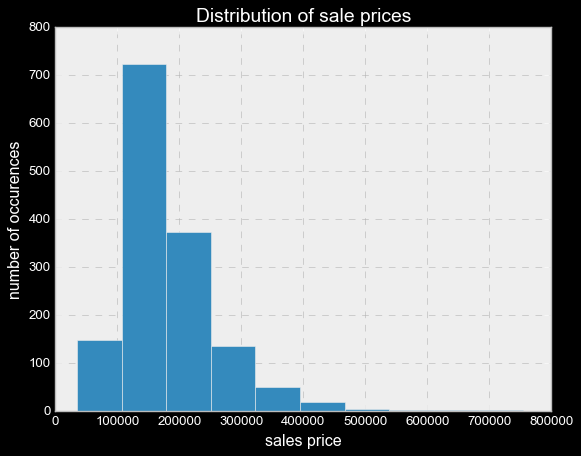

In [332]:
plt.style.use('bmh')

plt.hist(houseprices_df.saleprice)
plt.title('Distribution of sale prices')
plt.xlabel('sales price')
plt.ylabel('number of occurences')
plt.show()

The distribution of the sales prices is not normal. This is going to be the targer variable for our Regression analysis.

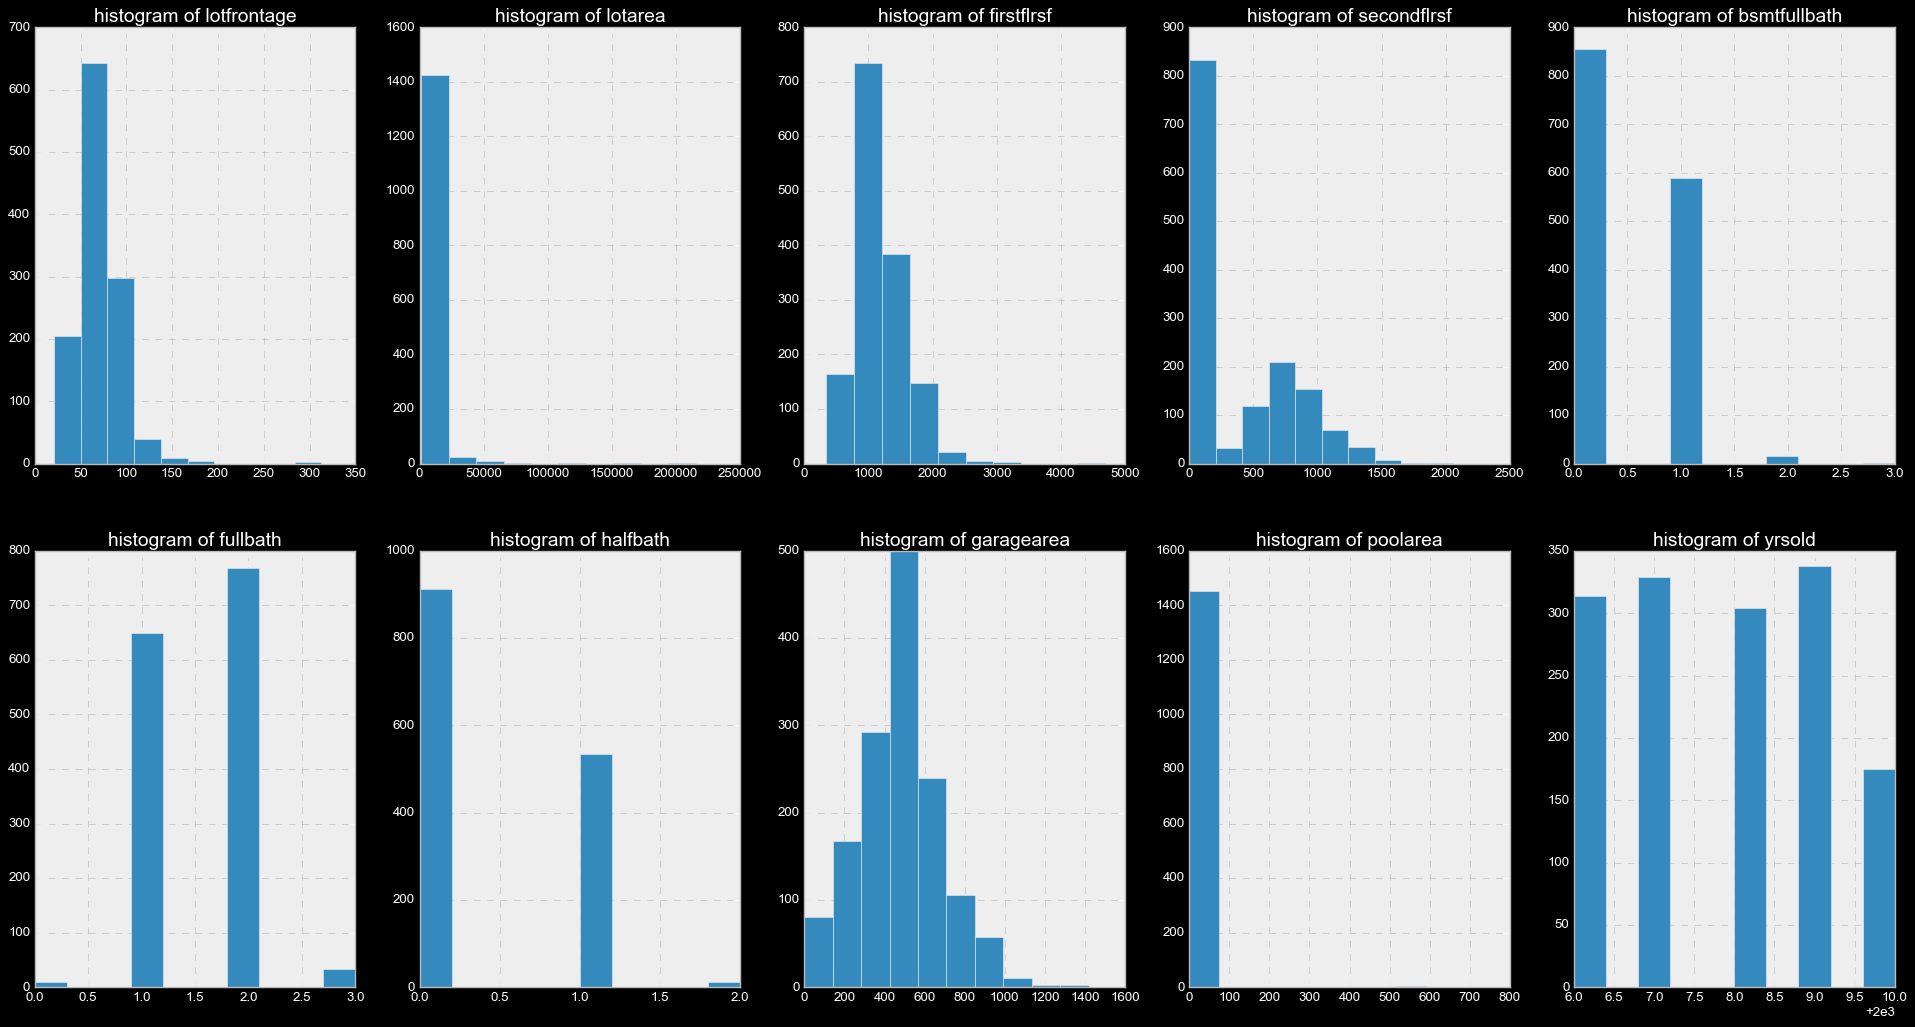

In [333]:
# As a part of univariate analysis, Checking the distribution of data



plt.figure(figsize=(30,15))
plt.style.use('bmh')

#histogram of original data
plt.subplot(2,5,1)
plt.hist(houseprices_df.lotfrontage)
plt.title('histogram of lotfrontage')


plt.subplot(2,5,2)
plt.hist(houseprices_df.lotarea)
plt.title('histogram of lotarea')


plt.subplot(2,5,3)
plt.hist(houseprices_df.firstflrsf)
plt.title('histogram of firstflrsf')


plt.subplot(2,5,4)
plt.hist(houseprices_df.secondflrsf)
plt.title('histogram of secondflrsf')


plt.subplot(2,5,5)
plt.hist(houseprices_df.bsmtfullbath)
plt.title('histogram of bsmtfullbath')


plt.subplot(2,5,6)
plt.hist(houseprices_df.fullbath)
plt.title('histogram of fullbath')


plt.subplot(2,5,7)
plt.hist(houseprices_df.halfbath)
plt.title('histogram of halfbath')


plt.subplot(2,5,8)
plt.hist(houseprices_df.garagearea)
plt.title('histogram of garagearea')


plt.subplot(2,5,9)
plt.hist(houseprices_df.poolarea)
plt.title('histogram of poolarea')


plt.subplot(2,5,10)
plt.hist(houseprices_df.yrsold)
plt.title('histogram of yrsold')





plt.show()

In [334]:
#Creating some object columns that I might be interested in as a variable

object_column = houseprices_df[['neighborhood','lotshape','street','garagetype','poolqc','fence','heating','housestyle','salecondition']]


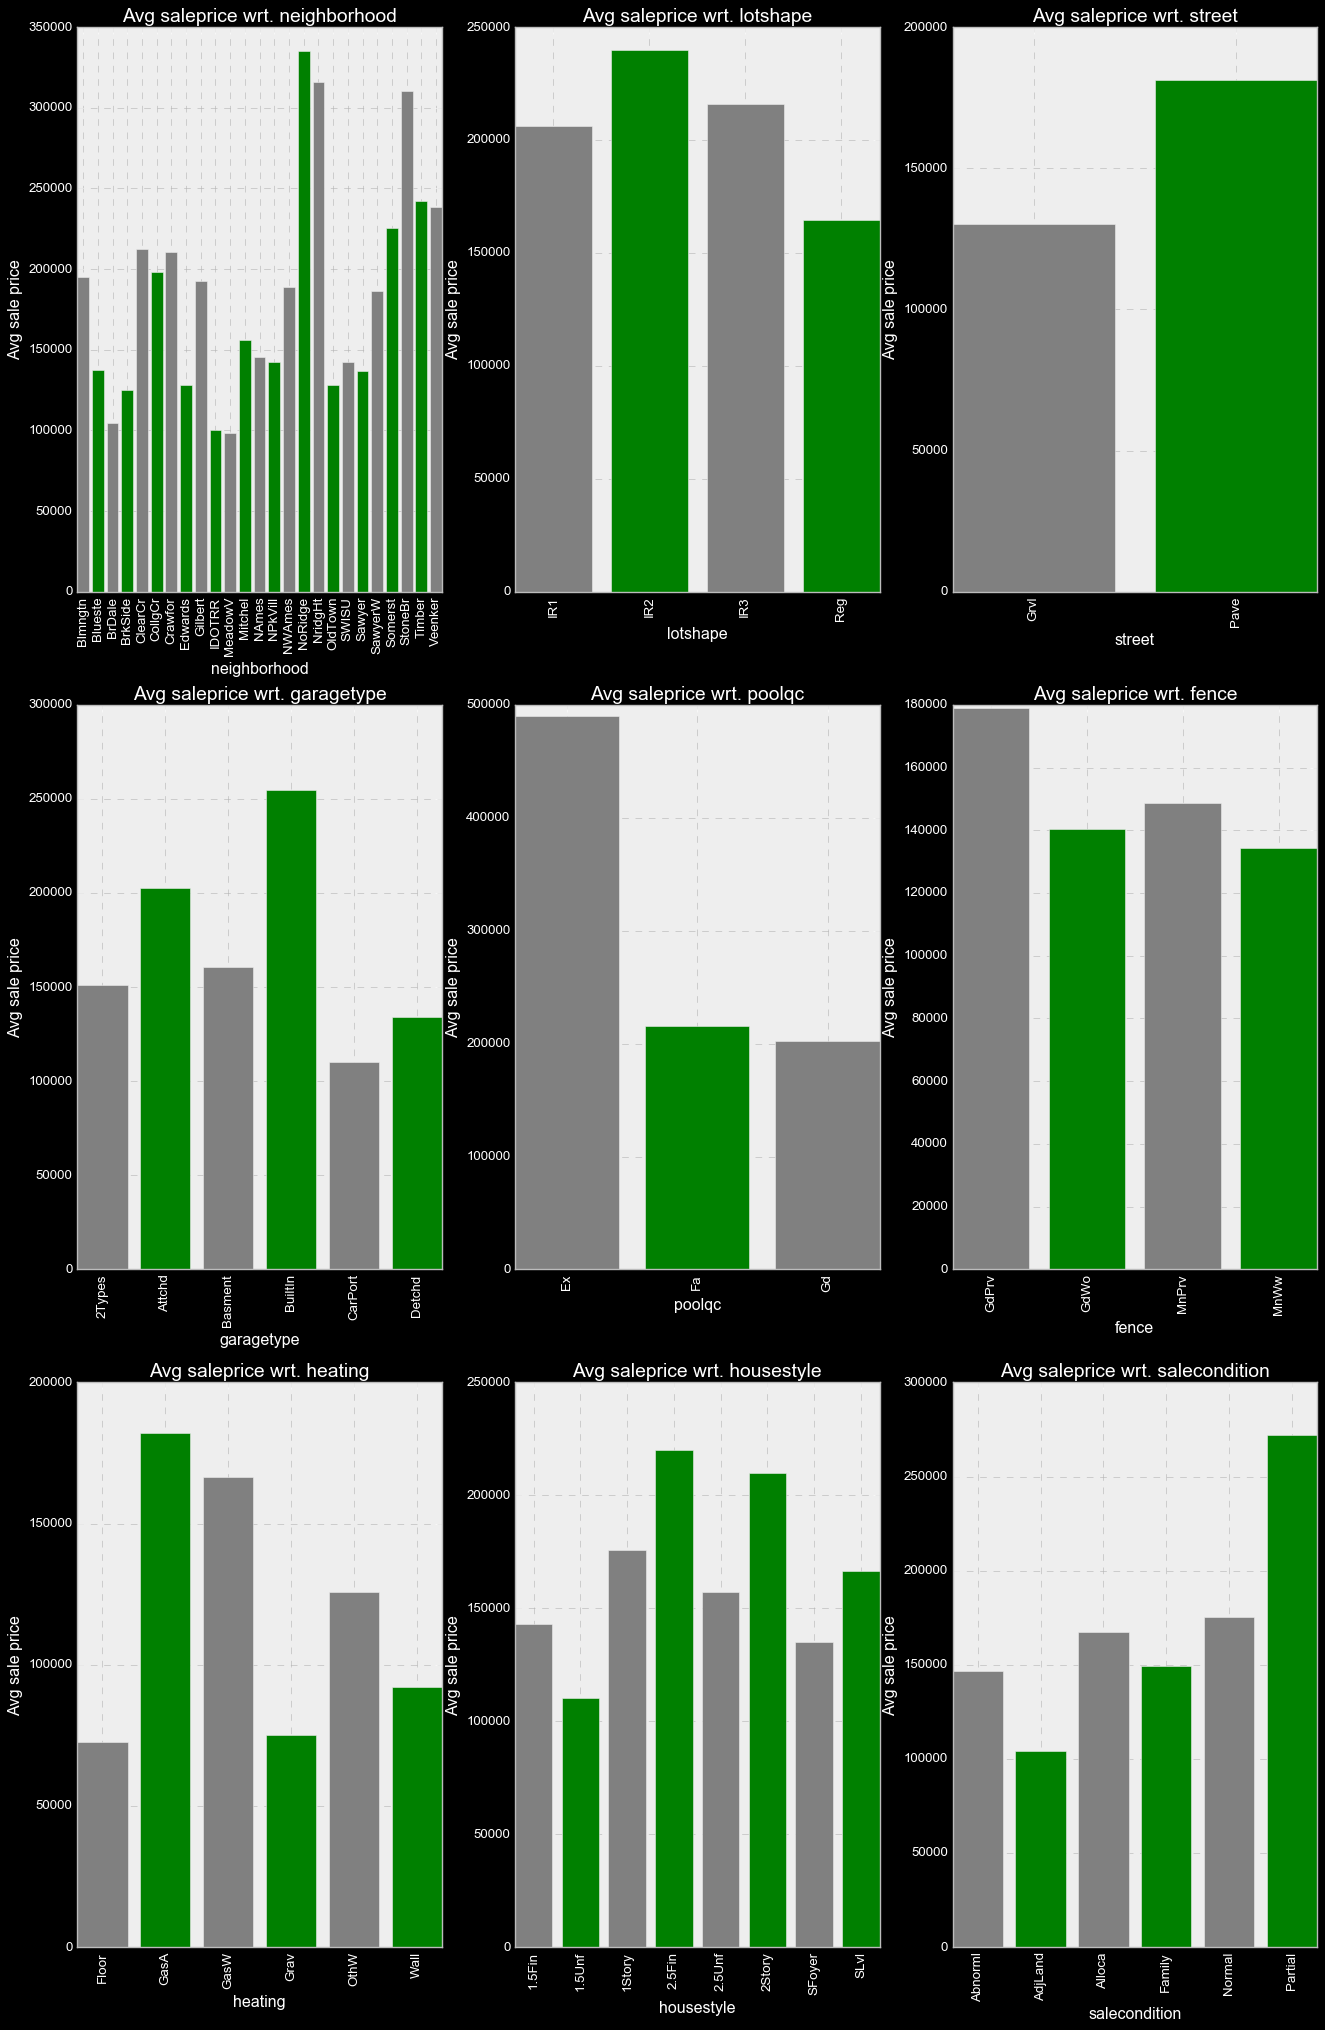

In [335]:
plt.figure(figsize=(20,30))


for index, column in enumerate(object_column):
    plt.subplot(3,3,index+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index,   houseprices_df.groupby(column)['saleprice'].mean(),color=('grey','green'))
    plt.title("Avg saleprice wrt. {}".format(column))
    plt.ylabel("Avg sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')
    
plt.show()




In [336]:
#displaying what the saleprice mean grouping looks like
houseprices_df.groupby(column)['saleprice'].mean()

salecondition
Abnorml    146526.623762
AdjLand    104125.000000
Alloca     167377.416667
Family     149600.000000
Normal     175202.219533
Partial    272291.752000
Name: saleprice, dtype: float64

The below is a correlation for the columns with numeric values and the target variables:

In [337]:
numeric_columns = houseprices_df.select_dtypes(['int64', 'float64']).columns


np.abs(houseprices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Our model will choose the 7 most correlated features with saleprice. The variable neighborhood and garagetype will be the two non-numerical variables that will be transformed to dummy variables so we can use them in our regression.

In [338]:
houseprices_df = pd.concat([houseprices_df, pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df, pd.get_dummies(houseprices_df.garagetype, prefix="garagetype", drop_first=True)], axis=1)
columnname_dummy = list(pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True).columns)
columnname_dummy = columnname_dummy + list(pd.get_dummies(houseprices_df.garagetype, prefix="garagetype", drop_first=True).columns)


# Regression Model

In [339]:
X = houseprices_df[['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf','firstflrsf','fullbath'] + columnname_dummy]

Y = houseprices_df.saleprice


In [340]:
X  = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     170.2
Date:                Sat, 08 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:23:34   Log-Likelihood:                -17326.
No. Observations:                1460   AIC:                         3.473e+04
Df Residuals:                    1423   BIC:                         3.492e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.997e+04   1.19e+04     -4.188      0.000   -7.34e+04   -2.66e+04
overallqual           1.655e+04   1175.372     14.080      0.000    1.42e+04    1.89e+04
grlivarea               42.0870      3.121     13.484      0.000      35.964      48.210
garagecars            1.228e+04   3019.396      4.066      0.000    6352.492    1.82e+04
garagearea              14.2082      9.998      1.421      0.155      -5.404      33.820
totalbsmtsf             16.9495      4.010      4.227      0.000       9.083      24.816
firstflrsf              11.8536      4.952      2.394      0.017       2.139      21.568
fullbath             -2024.4708   2550.282     -0.794      0.427   -7027.187    2978.245
neighborhood_Blueste -1.122e+04   2.63e+04     -0.427      0.670   -6.28e+04    4.03e+04
neighborhood_BrDale  -8221.1626   1.28e+04     -0.644      0.520   -3.33e+04    1.68e+04
neighborhood_BrkSide  1.087e+04   1.03e+04      1.052      0.293   -9403.935    3.12e+04
neighborhood_ClearCr  3.423e+04   1.11e+04      3.088      0.002    1.25e+04     5.6e+04
neighborhood_CollgCr  1.924e+04   9129.966      2.107      0.035    1328.703    3.71e+04
neighborhood_Crawfor  3.577e+04   1.02e+04      3.494      0.000    1.57e+04    5.58e+04
neighborhood_Edwards  1131.1226   9766.885      0.116      0.908    -1.8e+04    2.03e+04
neighborhood_Gilbert  1.453e+04   9589.832      1.515      0.130   -4278.444    3.33e+04
neighborhood_IDOTRR  -3090.7918    1.1e+04     -0.280      0.780   -2.48e+04    1.86e+04
neighborhood_MeadowV   880.1535   1.26e+04      0.070      0.944   -2.38e+04    2.56e+04
neighborhood_Mitchel  6243.0340   1.01e+04      0.619      0.536   -1.35e+04     2.6e+04
neighborhood_NAmes    6222.8698   9258.366      0.672      0.502   -1.19e+04    2.44e+04
neighborhood_NPkVill -6329.7690   1.45e+04     -0.435      0.663   -3.48e+04    2.22e+04
neighborhood_NWAmes   3467.5936   9617.776      0.361      0.718   -1.54e+04    2.23e+04
neighborhood_NoRidge  7.163e+04   1.05e+04      6.832      0.000    5.11e+04    9.22e+04
neighborhood_NridgHt  6.718e+04   9604.893      6.994      0.000    4.83e+04     8.6e+04
neighborhood_OldTown -8029.6029   9765.682     -0.822      0.411   -2.72e+04    1.11e+04
neighborhood_SWISU   -3010.6907   1.18e+04     -0.256      0.798   -2.61e+04    2.01e+04
neighborhood_Sawyer   9946.2295   9870.325      1.008      0.314   -9415.721    2.93e+04
neighborhood_SawyerW  1.274e+04   9809.568      1.298      0.194   -6506.182     3.2e+04
neighborhood_Somerst  2.853e+04   9508.552      3.000      0.003    9873.687    4.72e+04
neighborhood_StoneBr  7.127e+04   1.11e+04      6.411      0.000    4.95e+04    9.31e+04
neighborhood_Timber   3.064e+04   1.03e+04      2.979      0.003    1.05e+04    5.08e+04
neighborhood_Veenker  4.842e+04   1.36e+04      3.549    